# PyHoltz Example: Orr-Sommerfeld Equation

This is a python port of the Orr-Sommerfeld example from the matlab toolbox "NLEVP: A Collection of Nonlinear Eigenvalue Problems"
by  T. Betcke, N. J. Higham, V. Mehrmann, C. Schröder, and F. Tisseur. 

See
T. Betcke, N. J. Higham, V. Mehrmann, C. Schröder, and F. Tisseur, NLEVP: A Collection of Nonlinear Eigenvalue Problems, MIMS EPrint 2011.116, December 2011.
or
T. Betcke, N. J. Higham, V. Mehrmann, C. Schröder, and F. Tisseur, NLEVP: A Collection of Nonlinear Eigenvalue Problems. Users' Guide, MIMS EPrint 2010.117, December 2011.

The original toolbox is available at :
http://www.maths.manchester.ac.uk/our-research/research-groups/numerical-analysis-and-scientific-computing/numerical-analysis/software/nlevp/





## Orr-Sommerfeld Equation

The Orr-Sommerfeld equation reads as:
\begin{equation}
\left( \left( \frac{d^2}{dy^2}-\omega^2  \right)^2 - iRe \left( \left( \omega U - w \right)\left( \frac{d^2}{dy^2}-\omega^2 \right) - \omega U'' \right) \right) v= 0 
\end{equation}

The Orr–Sommerfeld equation governs modal stability of parallel flows. The x-coordinate points into the flow direction, while the y-direction is set perpendicular to it. In this example, plane Couette flow is considered, with walls
at $y = ±1$. The laminar base velocity profile is parabolic, $U = 1 − y^2$ . $Re$ denotes the Reynolds number. No-slip
boundary conditions must be satisfied by the mode $v$ at the walls:
$$v(±1)=v'(±1)=0 $$

Discretised using FEM discretisation the equation reads as:
\begin{equation}
L(\omega,Re) = \omega^4 \mathbf{I} + i\omega^3 Re \mathbf{U} - 2\omega^2 \mathbf{D_2} - i \omega^2 w Re \mathbf{I} -i\omega Re (\mathbf{U} \mathbf{D_2}+2\mathbf{I}) + iwRe\mathbf{D_2} + \mathbf{D_4} - \lambda \mathbf{I}
\end{equation}

The last term $-\lambda \mathbf{I}$ is an artificial term, which is needed for the Householder method.
For a deeper theoretical unterstanding see [Reference to paper]. 



## PyHoltz Package
### Imports and Functions
PyHoltz makes it possible to create and solve the $L(\omega,w)$ operator for eigenvalues.
The first step is to import all required packages. Make sure that PyHoltz was properly installed. If not:
- Download PyHoltz from [Link to Package]
- $>>$ cd 'into the download package'
- $>>$ python setup.py install  

In [1]:
import numpy as np
import numpy.matlib as npm
from PyHoltz.NLEVP.all_algebra import pow1, pow2, pow_a
from PyHoltz.NLEVP.parameter import para_model
from matplotlib import pyplot as plt
import matplotlib as mtlb
import warnings
warnings.filterwarnings("ignore")

PyHoltz package imported.


To create the 1D FEM discretisation Chebyshev nodes are used, which can be created using the following function.
The function returns D, the diffenrentiation matrix and x, the Chebyshev grid.

From:
Lloyd N. Trefethen. Spectral Methods in MATLAB. Society for Industrial
and Applied Mathematics, Philadelphia, PA, USA, 2000.

In [2]:
def cheb(N):
    #CHEB     Compute D = differentiation matrix, x = Chebyshev grid.
    #
    # From:
    # Lloyd N. Trefethen. Spectral Methods in MATLAB. Society for Industrial
    # and Applied Mathematics, Philadelphia, PA, USA, 2000.
    if N== 0:
        D=0
        x=1
        return D,x
    
    x = np.matrix(np.cos(np.pi*np.r_[0:N+1]/N)).H
    c = np.matrix(np.hstack((2, np.ones(N-1),2))*((-1)**np.r_[0:N+1])).H
    X = npm.repmat(x,1,N+1)     
    dX= X-X.H
    D =(c*(1/c.H))/(dX+np.eye(N+1)) # off-diagonal entries
    D=D -np.diag(np.array(np.sum(D,1))[:,0]) #diagonal entries
    return D,np.array(x)[:,0]

PyHoltz main object $para\_ model()$ (PyHoltz.NLEVP.parameter.para_model()) makes it possible to handle FEM discretised equations. The object also supports several functions to solve the problem for eigenvalues. All required steps are wrapped in the function $orr\_ sommerfeld()$ below.
1. The function creates the discretisation matrices $\mathbf{I}$,$\mathbf{D}$,$\mathbf{D_2}$ and $\mathbf{D_4}$.
2. All parameters are added the para_model() instance.
3. All discretisation matrices are added to the instance.
4. Return of instance and Chebyshev nodes.

In [3]:
def orr_sommerfeld(N=64, R=5772, w =0.26943):
    N=N+1
    # 2nd- and 4th-order differntiation matrices:
    D,x=cheb(N); D2 =D**2;  D2 = D2[1:N,1:N]
    S= np.diag(np.hstack((0, 1/(1-x[1:N]**2),0)))
    D4=(np.diag(1-x**2)*D**4-8*np.diag(x)*D**3-12*D**2)*S
    D4 = D4[1:N,1:N]

    I=npm.eye(N-1)
#    A4=I
#    A3= 1j*R*npm.diag(1-x[1:N]**2)
#    A2= -2*D2-1j*w*R*I
#    A1= -1j*R*(npm.diag(1-x[1:N]**2)*D2)-2j*R*I
#    A0= D4+1j*w*R*D2
#          
    # type conversion
    I=I.astype('complex')
    D2=D2.astype('complex') 
    D4=D4.astype('complex')    

     
#    Orr-Sommerfeld operator
    L=para_model()
    L.add_param('ω',1.) #eigenvalue is always present
    L.add_param('w',w)
    L.add_param('R',R)
    L.add_param('λ',0)
    L.add_term({'matrix':I,'functions':[pow_a(4)],'parameters':[['ω']],'operator':'I'})
    L.add_term({'matrix':1j*npm.diag(1-x[1:N]**2),'functions':[pow_a(3),pow1],'parameters':[['ω'],['R']],'operator':'A3'})
    L.add_term({'matrix':-2*D2,'functions':[pow2],'parameters':[['ω']],'operator':'-2*D2'})
    L.add_term({'matrix':-1j*I,'functions':[pow2,pow1,pow1],'parameters':[['ω'],['w'],['R']],'operator':'-1j*I'})
    L.add_term({'matrix':-1j*(npm.diag(1-x[1:N]**2)*D2)-2j*I,'functions':[pow1,pow1],'parameters':[['ω'],['R']],'operator':'A1'})
    L.add_term({'matrix':1j*D2,'functions':[pow1,pow1],'parameters':[['w'],['R']],'operator':'1jD2'})
    L.add_term({'matrix':D4,'functions':[],'parameters':[],'operator':'D4'}) 
    L.add_term({'matrix':-I,'functions':[pow1],'parameters':[['λ']],'operator':'-I'})
    return L,x           
    



### Create object and find eigenvalue

Now $orr\_ sommerfeld()$ function is called and the discretised non-linear eigenvalue porblem is stored in $L$.
To compare results with the reference solution the same parameters are used. $64$ grid points, Reynoldnumber of $5772$ and frequency is set to $0.26943$.
Additionally the problem is solved using the householder method of oder three. The first parameter defines the starting point for the iterative algorithm.

In [4]:
print('Collect grid points...')
L,x=orr_sommerfeld(N=64, R=5772, w =0.26943)
print('run solver....')
L.householder(1,order=3,maxiter=50)
L.get_value('ω')
print('Eigenvalue:  '+str(L.get_value('ω')))

Collect grid points...
run solver....
Eigenvalue:  (1.0205563450177282+9.742150748206857e-07j)


### Perturbation Theory
Another feature of PyHoltz is perturbation theory. 
The idea is to find solutions of perturbed systems without solving the whole system agian.
The theory is further discribed in [Link to paper].
Executing the next cell can take a few minutes depending on the order of perturbation theory.
Set order to 15 for a first impression.

In [5]:
order = 15

In [7]:
#%%
L.p/=L.p[0].item(0)
print('Perform perturbation calculations:',flush=True)
L.perturb_parallel('R',order,normalize=True,info=True)

sol=L.solution()
sol.normalize_pert()


#%%
#sol.estimate_pol()
lam=L.omega_pert.copy()

#%%
expand=1.0
start=sol.eps0-5601
stop=sol.eps0+5601
#start=sol.eps0-sol.conv_radius[-1]*expand
#stop=sol.eps0+sol.conv_radius[-1]*expand
#%%                             
#start=sol.eps0-sol.eps0
#stop=sol.eps0+sol.eps0

#start=-14.5
#stop = +14.5
eps=np.linspace(start,stop,101) #101
eps=np.round(eps).astype(int)
Eps=np.linspace(start,stop,1001) #1001

#%%
from ipywidgets import FloatProgress
from IPython.display import display
print('Calculate exact solutions:')
max_count = 100
f = FloatProgress(min=0, max=max_count,bar_style='success') # instantiate the bar
display(f) # display the bar

lam_exact=[]
v_exact=[]
e=eps[50]
tempsol=sol
for idx,e in enumerate(eps[50:]):
    #print(idx)
    L.set_value(sol.epsilon,e)
    L.householder(tempsol.poly(e,3),tol=1E-12,maxiter=30,output=False,order=1)
    lam_exact+=[L.omega.item(0)]
    v_exact+=[L.p]
    L.perturb_parallel(sol.epsilon,3,normalize=True)
    tempsol=L.solution()
    f.value += 1 # signal to increment the progress bar


tempsol=sol
for idx,e in enumerate(reversed(eps[0:50])):
    #print(idx)
    L.set_value(sol.epsilon,e)
    L.householder(tempsol.poly(e,3),tol=1E-12,maxiter=30,output=False,order=1)
    lam_exact=[L.omega.item(0)]+lam_exact
    v_exact=[L.p]+v_exact
    L.perturb_parallel(sol.epsilon,3,normalize=True)
    tempsol=L.solution()
    f.value += 1 # signal to increment the progress bar

    
    
lam_exact=np.array(lam_exact)

#%% normalize exact v
v0=sol.p_pert[0]
#v0/=v0[0].item(0)


for i in range(len(v_exact)):
    #print(np.abs(np.exp(np.angle(v0.H*v_exact[i])*1j)))
    v_exact[i]/=np.exp(np.angle(v0.H*v_exact[i])*1j).item(0)
    v_exact[i]/=np.linalg.norm(v_exact[i])
    


x=x[1:-1]
print('All calculations completed.')


Perform perturbation calculations:


FloatProgress(value=0.0, bar_style='success', max=15.0)

Calculate exact solutions:


FloatProgress(value=0.0, bar_style='success')

All calculations finished completed.


### Post-processing 

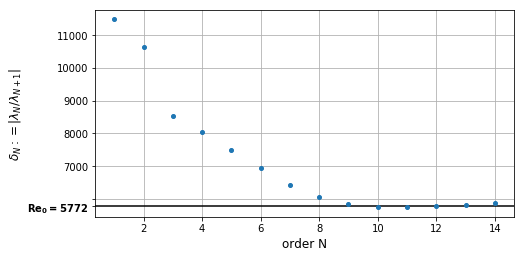

In [6]:
#%%Convergence plots
alestest=np.array(sol.omega_pert)
plt.close('all')
plt.figure('convergence',figsize=(6.4/1.3*2*.75,4.8/1.3))
#plt.subplot(121)
plt.plot(np.r_[1:order],np.abs(alestest[1:-1]/alestest[2:]),'.',ms=8)
#plt.yticks([0,5772,10000,20000,30000,40000],['0',r'$\mathbf{5772}$','10000', '20000','30000','40000'])
plt.yticks([5772,6000,7000,8000,9000,10000,11000],[r'$\mathbf{\mathrm{\mathbf{Re}}_0 = 5772}$','', '7000','8000','9000','10000','11000'])

#plt.plot(plt.xlim(),[5772,5772],'k',zorder=2)
plt.grid('on')
ax=plt.gca()
a=ax.get_ygridlines()
b = a[0]
b.set_color('k')
b.set_linewidth(1.5)
#plt.title('estimated radius of convergence')
plt.xlabel('order N',fontsize=12)
plt.ylabel(r'$\delta_N:=|\lambda_N/\lambda_{N+1}|$',fontsize=12)    
plt.tight_layout()




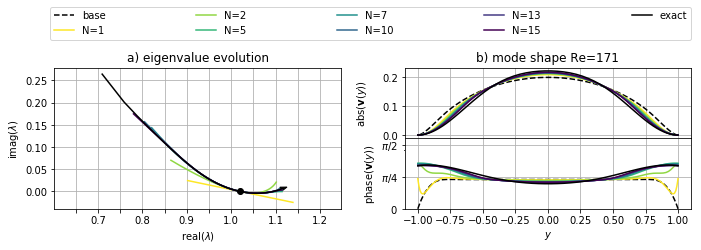

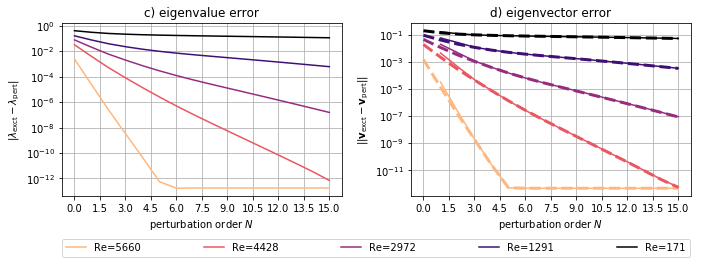

In [8]:

#%prepare colors
cmap=plt.get_cmap('viridis_r')
cmap2=plt.get_cmap('magma_r')
colors=cmap(np.linspace(0.,1.,6))
colors2=cmap2(np.linspace(0.,1.,6))


#%%
#mtlb.rc('text',usetex=True)
plt.close('all')
plt.figure('eigval',figsize=(6.4/1.3*2,4.8/1.3))
plt.subplot(121)
plt.title('a) eigenvalue evolution')
#plt.figure('modeshape',figsize=(6.4/1.3,4.8/1.3))
#mode0=np.vstack((0,L.p,0))
#mode0=L.p
mode0=sol.v[0]

plt.subplot(222)
plt.plot(x,np.abs(mode0),'--k',label='base')
plt.subplot(224)
plt.plot(x,np.angle(mode0),'--k',label='base')
#exmpl=100
exmpl=0

if order >=15:
    levels=[1,2,5,7,10,13,15]
if order>=30:
    levels=[1,2,5,10,15,20,30]
if order >=50:
    levels=[1,2,5,10,15,25,50]
for N, clr in zip(levels,cmap(np.linspace(0.,1,len(levels)))):#,25]:#range(0,25):
    lams=sol.poly(Eps,N)
    plt.subplot(121)
    plt.plot(np.real(lams),np.imag(lams),color=clr,label='N='+str(N))
    mode=sol.polyP(eps[exmpl],N)
    plt.subplot(222)
    plt.plot(x,np.abs(mode),color=clr,label='N='+str(N))
    plt.subplot(224)    
    plt.plot(x,np.angle(mode),color=clr,label='N='+str(N))

#plt.figure('eigval')
plt.subplot(121)    
plt.plot(np.real(sol.omega),np.imag(sol.omega),'ko')
plt.plot(np.real(lam_exact),np.imag(lam_exact),'k', label='exact')
plt.arrow(np.real(lam_exact[-2]),np.imag(lam_exact[-2]),np.real(lam_exact[-1]-lam_exact[-2]),np.imag(lam_exact[-1]-lam_exact[-2]),fc="k",ec="k",head_width=.01)
#plt.legend()
plt.grid('on')
plt.xlabel('real($\lambda$)')
plt.ylabel('imag($\lambda$)')
plt.xticks(np.linspace(0.6,1.25,14),['0.6','','0.7','','0.8','','0.9','','1.0','','1.1','','1.2',''])
#plt.xlim([0.7, 1.1])
#plt.tight_layout()
#plt.figure('modeshape')    
#mode=np.vstack((0,v_exact[exmpl],0))
mode=v_exact[exmpl]
#mode0=np.vstack((0,L.p,0))
plt.subplot(222)
plt.plot(x,np.abs(mode),'k',label='exact')
plt.legend(bbox_to_anchor=(-1.24,+1.4,2.24, 0.102), loc=3, mode = "expand", borderaxespad=0,ncol=5)


plt.ylabel('abs$(\mathbf{v} (y))$',labelpad=13)
plt.grid('on')
plt.title(r'b) mode shape Re='+str(eps[exmpl]))
plt.subplot(224)    
plt.plot(x,np.angle(mode),'k',label='exact')


#plt.yticks(np.linspace(-np.pi,np.pi,5),['$-\pi$','$-\pi/2$','$0$','$+\pi/2$','$+\pi$'])
plt.ylim(-0*1.1*np.pi,np.pi*1.1/2)
plt.yticks(np.linspace(0,np.pi/2,3),['$0$','$\pi/4$','$\pi/2$'])
#plt.ylim(-0*1.1*np.pi,np.pi*1.1/4)
#plt.yticks(np.linspace(0,np.pi/4,3),['$0$','$+\pi/8$','$+\pi/4$'])

plt.xlabel('$y$')
plt.ylabel('phase$(\mathbf{v} (y))$')
plt.grid('on')


plt.tight_layout(rect=[0,0,1,0.8])

plt.subplot(121)
plt.axis('equal')


f=plt.gcf()
f.subplots_adjust(hspace=0.0)




plt.close('error')
plt.figure('error',figsize=(12.8/1.3,4.8/1.3))
#plt.figure('norm')

L.active=['ω',sol.epsilon]
#['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#levels=[51,62,75,90,100]
levels=[49,38,25,10,0]
for O, color in zip(levels,cmap2(np.linspace(0.15,1.,len(levels)))):
    err=[]
    errV=[]
    errP=[]
    norm=[]
    for N in range(0,order+1):
        #print(N)
        err+=[lam_exact[O]-sol.poly(eps[O],N)]
        
        
        
        Vp=np.matrix(sol.polyP(eps[O],N))
        V1=Vp.copy()
        #minimum residual
        Vp/=np.linalg.norm(Vp)
        vec_a=L(sol.poly(eps[O],N),eps[O])*Vp
        vec_b=L(sol.poly(eps[O],N),eps[O])*sol.p_pert[0]
        c=(vec_a.H*vec_b).item(0)/(vec_b.H*vec_b).item(0)
        Vp=Vp-np.conj(c)*sol.p_pert[0]
        Vp/=np.exp(np.angle(v0.H*Vp)*1j).item(0) #stick to phase convention
        Vp/=np.linalg.norm(Vp)
        Vx=v_exact[O].copy()
        Vx/=np.linalg.norm(Vx)
        
        res0=Vx-Vp
        #iterative scheme
        Vp=np.matrix(sol.polyP(eps[O],N))
        #print('This should be zero:',np.sum(np.abs(V1-Vp)))
        Vx=v_exact[O].copy()
        #res=Vx-(Vp.H*Vx).item(0)*Vp
        res=Vx-Vp 
       
        errP+=[np.sqrt(res0.H*res0).item(0)]
        errV+=[np.sqrt(res.H*res).item(0)]
        
    err=np.array(err)
    errV=np.array(errV)
    plt.figure('error')
    plt.subplot(121)    
    plt.semilogy(np.abs(err),color=color,label='Re='+str(eps[O]))
    plt.subplot(122)
    plt.semilogy(np.abs(errP),'-',color=color,label='Re='+str(eps[O]))
    
    #plt.gca().set_prop_cycle(None)
    plt.hold('all')
    plt.semilogy(np.abs(errV),'--',color=color,label='__nolabel__',lw=3)
    plt.hold('on')
    #plt.figure('norm')
    plt.semilogy(norm)
    
    
    


plt.figure('error')

plt.subplot(121)
#plt.legend()
plt.grid('on')
plt.xlabel('perturbation order $N$')
plt.ylabel('$|\lambda_\mathrm{exct}-\lambda_\mathrm{pert}|$')
plt.title('c) eigenvalue error')
plt.xticks(np.linspace(0,order,11))
plt.legend(bbox_to_anchor=(0,-.35,2.24, 0.102), loc=3, mode = "expand", borderaxespad=0,ncol=5)
plt.subplot(122)
plt.grid('on')
plt.xlabel('perturbation order $N$')
plt.xticks(np.linspace(0,order,11))
plt.ylabel(r'$||\mathbf{v}_\mathrm{exct}-\mathbf{v}_\mathrm{pert}||$')        
#plt.suptitle('Errors')
plt.title('d) eigenvector error')
L.active=['ω']
plt.tight_layout(rect=[0,0.075,1,1])
